# 0.0 Importing the data

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1xEsjutddVtMKisrUPfPVSdKouFnv70C_'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [ ]:
!mkdir /content/IDC_files
!unzip -q /content/archive.zip -d /content/IDC_files 

# 1.0 Preprocessing

In [ ]:
import os
import random 
from glob import glob
from pathlib import Path
DATASET_DIR = os.path.join("/content", "IDC_files","content","IDC_patients")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")
VAL_DIR = os.path.join(DATASET_DIR, "val")

all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*png'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]
print(len(all_data))

277524


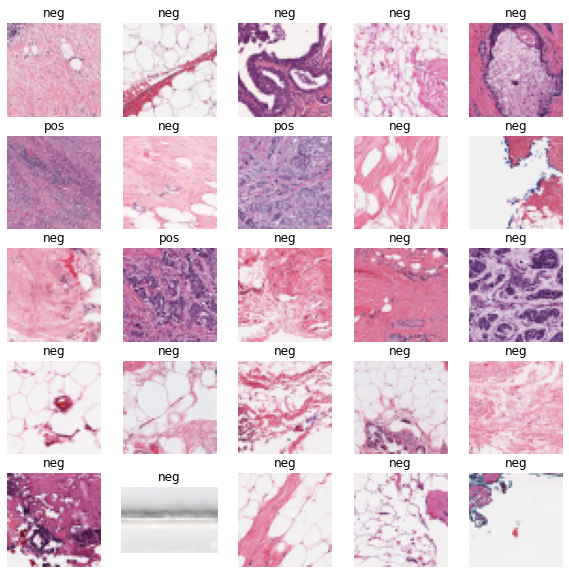

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

 Seeing different channels of of sample image

In [ ]:
POS_TRAIN_DIR = os.path.join(TRAIN_DIR, "pos")
train_poss = os.listdir(POS_TRAIN_DIR)
sample_train_pos = train_poss[:5]
sample_train_pos = [str(POS_TRAIN_DIR+"/" + x) for x in sample_train_pos]
sample_train_pos

['/content/IDC_files/content/IDC_patients/train/pos/12908_idx5_x2401_y751_class1.png',
 '/content/IDC_files/content/IDC_patients/train/pos/13462_idx5_x1001_y2201_class1.png',
 '/content/IDC_files/content/IDC_patients/train/pos/12906_idx5_x2151_y1651_class1.png',
 '/content/IDC_files/content/IDC_patients/train/pos/16568_idx5_x1751_y551_class1.png',
 '/content/IDC_files/content/IDC_patients/train/pos/9345_idx5_x2751_y651_class1.png']

In [ ]:
NEG_TRAIN_DIR = os.path.join(TRAIN_DIR, "neg")
train_negs = os.listdir(NEG_TRAIN_DIR)
sample_train_neg = train_negs[:5]
sample_train_neg = [str(NEG_TRAIN_DIR+"/" + x) for x in sample_train_neg]
sample_train_neg

['/content/IDC_files/content/IDC_patients/train/neg/16551_idx5_x901_y2101_class0.png',
 '/content/IDC_files/content/IDC_patients/train/neg/9123_idx5_x2151_y2351_class0.png',
 '/content/IDC_files/content/IDC_patients/train/neg/16165_idx5_x2801_y251_class0.png',
 '/content/IDC_files/content/IDC_patients/train/neg/12750_idx5_x601_y501_class0.png',
 '/content/IDC_files/content/IDC_patients/train/neg/9176_idx5_x401_y1851_class0.png']

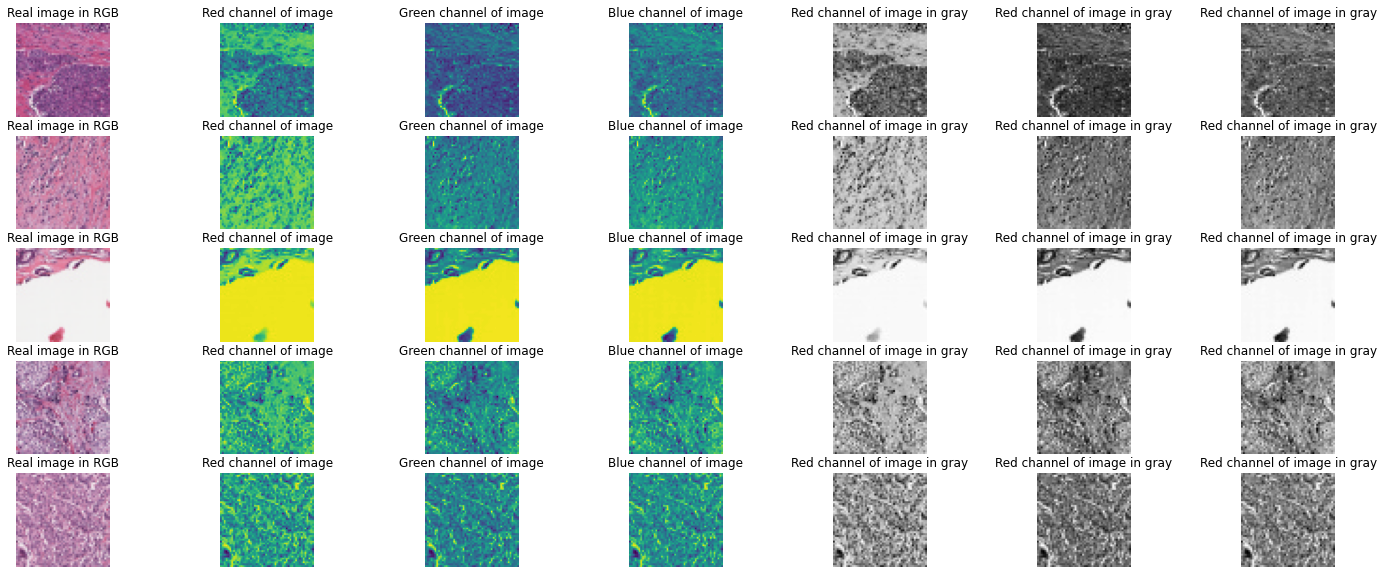

In [ ]:
import cv2
plt.figure(figsize = (25,10))
for i in range(len(sample_train_pos)):
    plt.subplot(5, 7, i*7 + 1)
    image = cv2.imread(sample_train_pos[i], cv2.IMREAD_COLOR )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title("Real image in RGB")
    plt.axis('off')
    #Red
    plt.subplot(5, 7, i*7 + 2)
    plt.imshow(image[:,:,0])
    plt.title("Red channel of image")
    plt.axis('off')
    #Green
    plt.subplot(5, 7, i*7 + 3)
    plt.imshow(image[:,:,1])
    plt.title("Green channel of image")
    plt.axis('off')
    #Blue
    plt.subplot(5, 7, i*7 + 4)
    plt.imshow(image[:,:,2])
    plt.title("Blue channel of image")
    plt.axis('off')

    #Red in gray
    plt.subplot(5, 7, i*7 + 5)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.title("Red channel of image in gray")
    plt.axis('off')

    #Green in gray
    plt.subplot(5, 7, i*7 + 6)
    plt.imshow(image[:,:,1], cmap='gray')
    plt.title("Red channel of image in gray")
    plt.axis('off')

    #Blue in gray
    plt.subplot(5, 7, i*7 + 7)
    plt.imshow(image[:,:,2], cmap='gray')
    plt.title("Red channel of image in gray")
    plt.axis('off')

I see the contrast is much better in Red images, so let's consider only the red channel of images

However for transfer learning i will have to train with RGB.

# Intializing Data generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 256
HEIGHT = 50
WIDTH = 50

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = False, # Would vertical_flip = True be a good choice for data augmentation?
      brightness_range=[0.2,1],
      height_shift_range=[-200,200],
      width_shift_range=[-200,200],
      zoom_range=[0.5,1],
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
os.listdir(TRAIN_DIR),len(os.listdir(os.path.join(TRAIN_DIR,"pos"))),len(os.listdir(os.path.join(TRAIN_DIR,"neg")))

(['pos', 'neg'], 49174, 121957)

In [ ]:
os.listdir(VAL_DIR),len(os.listdir(os.path.join(VAL_DIR,"pos"))),len(os.listdir(os.path.join(VAL_DIR,"neg")))

(['pos', 'neg'], 15010, 37896)

In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen =  ImageDataGenerator(
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = False, # Would vertical_flip = True be a good choice for data augmentation?
      brightness_range=[0.2,1],
      height_shift_range=[-200,200],
      width_shift_range=[-200,200],
      zoom_range=[0.5,1],
    )

# 2. Retrieve the iterator
val_generator = val_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = False, # Would vertical_flip = True be a good choice for data augmentation?
      brightness_range=[0.2,1],
      height_shift_range=[-200,200],
      width_shift_range=[-200,200],
      zoom_range=[0.5,1],
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


# Model 1 VGG 16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model.summary()

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
!pip install ktrain

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
668/668 [==============================] - 477s 702ms/step - loss: 0.6387 - accuracy: 0.6231
Epoch 2/5
668/668 [==============================] - 409s 612ms/step - loss: 0.5437 - accuracy: 0.7158
Epoch 3/5
668/668 [==============================] - 374s 559ms/step - loss: 5.3349 - accuracy: 0.7092


done.
Visually inspect loss plot and select learning rate associated with falling loss


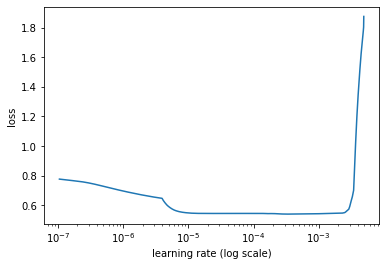

In [ ]:
import ktrain

learner = ktrain.get_learner(model,
                             train_data = train_generator,
                             val_data = val_generator,
                             batch_size = 256)

learner.lr_find(show_plot=True,
                max_epochs=5)

In [ ]:
# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

INITIAL_EPOCHS = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS,
                    callbacks=[es])

Epoch 1/10
669/669 [==============================] - 597s 892ms/step - loss: 0.5384 - accuracy: 0.7155 - val_loss: 0.5129 - val_accuracy: 0.7374
Epoch 2/10
669/669 [==============================] - 505s 754ms/step - loss: 0.5364 - accuracy: 0.7199 - val_loss: 0.5199 - val_accuracy: 0.7435
Epoch 3/10
669/669 [==============================] - 505s 755ms/step - loss: 0.5362 - accuracy: 0.7189 - val_loss: 0.5198 - val_accuracy: 0.7412
Epoch 4/10
669/669 [==============================] - 505s 755ms/step - loss: 0.5346 - accuracy: 0.7209 - val_loss: 0.5147 - val_accuracy: 0.7402
Epoch 5/10
669/669 [==============================] - 508s 759ms/step - loss: 0.5356 - accuracy: 0.7214 - val_loss: 0.5189 - val_accuracy: 0.7446
Epoch 6/10
669/669 [==============================] - 512s 765ms/step - loss: 0.5346 - accuracy: 0.7224 - val_loss: 0.5140 - val_accuracy: 0.7426
Epoch 7/10
669/669 [==============================] - 515s 770ms/step - loss: 0.5346 - accuracy: 0.7213 - val_loss: 0.5105 -

In [ ]:
model.save("model1")
model.save("model1.h5")

# Model 2

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 50
WIDTH = 50

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

NameError: ignored

In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
val_generator = val_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

NameError: ignored

In [ ]:
# Print summary
#model.summary()

# Compile
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

INITIAL_EPOCHS = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history2 = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 467s 173ms/step - loss: 0.6035 - accuracy: 0.7124 - val_loss: 0.5966 - val_accuracy: 0.7163
Epoch 2/10
2674/2674 [==============================] - 464s 174ms/step - loss: 0.6002 - accuracy: 0.7127 - val_loss: 0.5981 - val_accuracy: 0.7163
Epoch 3/10
2674/2674 [==============================] - 462s 173ms/step - loss: 0.6000 - accuracy: 0.7127 - val_loss: 0.5966 - val_accuracy: 0.7163
Epoch 4/10
2674/2674 [==============================] - 473s 177ms/step - loss: 0.6000 - accuracy: 0.7127 - val_loss: 0.5965 - val_accuracy: 0.7163
Epoch 5/10
2674/2674 [==============================] - 460s 172ms/step - loss: 0.5999 - accuracy: 0.7127 - val_loss: 0.5977 - val_accuracy: 0.7163
Epoch 6/10
2313/2674 [========================>.....] - ETA: 50s - loss: 0.6001 - accuracy: 0.7125

# Model 3

EfficientNetV2L

Lower batch size, and lower LR rate

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 50
WIDTH = 50

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
val_generator = val_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model = EfficientNetV2L(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model.summary()

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='tanh')(x)
x = Dense(256, activation='tanh')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='tanh')(x)
output = Dense(2, activation='softmax')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)



473186304/473176280 [==============================] - 3s 0us/step
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 50, 50, 3)    0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 25, 25, 32)   864         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 25, 25, 32)   128         ['stem_conv[0][0]']              
                

In [ ]:
# Print summary
#model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
2673/2673 [==============================] - 2552s 921ms/step - loss: 0.5853 - accuracy: 0.6900
Epoch 2/5
2673/2673 [==============================] - 2456s 919ms/step - loss: 0.3385 - accuracy: 0.8565
Epoch 3/5
2673/2673 [==============================] - 2458s 919ms/step - loss: 0.3641 - accuracy: 0.8433
Epoch 4/5
2673/2673 [==============================] - 1761s 658ms/step - loss: 1.2867 - accuracy: 0.7228


done.
Visually inspect loss plot and select learning rate associated with falling loss


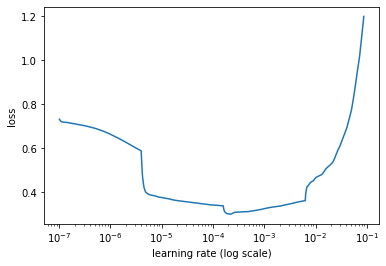

In [ ]:
import ktrain

learner = ktrain.get_learner(model,
                             train_data = train_generator,
                             val_data = val_generator,
                             batch_size = 64)

learner.lr_find(show_plot=True,
                max_epochs=5)

In [ ]:
# Print summary
#model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 1233s 434ms/step - loss: 0.3445 - accuracy: 0.8517 - val_loss: 0.2856 - val_accuracy: 0.8802
Epoch 2/10
2674/2674 [==============================] - 1142s 427ms/step - loss: 0.3048 - accuracy: 0.8732 - val_loss: 0.2834 - val_accuracy: 0.8826
Epoch 3/10
2674/2674 [==============================] - 1146s 429ms/step - loss: 0.3006 - accuracy: 0.8749 - val_loss: 0.3442 - val_accuracy: 0.8648
Epoch 4/10
2674/2674 [==============================] - 1143s 427ms/step - loss: 0.2896 - accuracy: 0.8802 - val_loss: 0.2829 - val_accuracy: 0.8830
Epoch 5/10
2674/2674 [==============================] - 1144s 428ms/step - loss: 0.2834 - accuracy: 0.8824 - val_loss: 0.2965 - val_accuracy: 0.8773
Epoch 6/10
2674/2674 [==============================] - 1188s 444ms/step - loss: 0.2784 - accuracy: 0.8855 - val_loss: 0.2935 - val_accuracy: 0.8769
Epoch 7/10
2674/2674 [==============================] - 1162s 435ms/step - loss: 0.2749 - accuracy: 0.8868

In [ ]:
model.save("model3")
model.save("model3.h5")

INFO:tensorflow:Assets written to: model3/assets


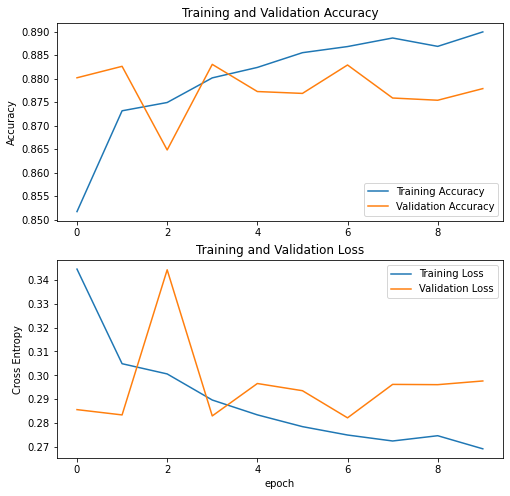

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model 4

Model 3 With different classifier, and adding more data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 50
WIDTH = 50

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = False, # Would vertical_flip = True be a good choice for data augmentation?
      brightness_range=[0.2,1],
      height_shift_range=[-200,200],
      width_shift_range=[-200,200],
      zoom_range=[0.5,1],
    )

# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
      rescale = 1.0/255,
      rotation_range = 20,
      vertical_flip = False, # Would vertical_flip = True be a good choice for data augmentation?
      brightness_range=[0.2,1],
      height_shift_range=[-200,200],
      width_shift_range=[-200,200],
      zoom_range=[0.5,1],
    )

# 2. Retrieve the iterator
val_generator = val_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model4 = EfficientNetV2L(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model4.summary()

# Mark loaded layers as not trainable
for layer in base_model4.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x4 = Flatten()(base_model4.layers[-1].output)
x4 = Dense(256, activation='tanh')(x4)
x4 = Dense(256, activation='tanh')(x4)
x4 = Dropout(0.25)(x4)
x4 = Dense(256, activation='tanh')(x4)

output4 = Dense(2, activation='softmax')(x4)
# Define new model
model4 = Model(inputs = base_model4.inputs, outputs = output4)



Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 rescaling_7 (Rescaling)        (None, 50, 50, 3)    0           ['input_8[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 25, 25, 32)   864         ['rescaling_7[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 25, 25, 32)   128         ['stem_conv[0][0]']              
                                                                                   

In [ ]:
# Print summary
#model.summary()

# Compile
base_learning_rate = 0.0001
model4.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history4 = model4.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 1169s 437ms/step - loss: 0.5662 - accuracy: 0.7079 - val_loss: 0.5564 - val_accuracy: 0.7163
Epoch 2/10
2674/2674 [==============================] - 1155s 432ms/step - loss: 0.5635 - accuracy: 0.7104 - val_loss: 0.6515 - val_accuracy: 0.6165
Epoch 3/10
2155/2674 [=======================>......] - ETA: 3:24 - loss: 0.5493 - accuracy: 0.7120

KeyboardInterrupt: ignored

In [ ]:
model4.save("model4")
model4.save("model4.h5")

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model 5

Accumlation on model 3 with SVM

In [ ]:
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.efficientnet_v2 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1-KFyh7fujm0RX4p8U42SJm80i5PE9SCV'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Model5.rar')

In [ ]:
!mkdir /content/model3_meta_data
!unrar x "/content/Model5.rar" "/content/model3_meta_data"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Model5.rar

Extracting  /content/model3_meta_data/model3.h5                            0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%  OK 
All OK


In [ ]:
from tensorflow import keras
model5 = keras.models.load_model('/content/model3_meta_data/model3.h5')

In [ ]:
model5.evaluate(test_generator)


827/827 [==============================] - 2006s 2s/step - loss: 0.3242 - accuracy: 0.8633


[0.3241555988788605, 0.8633236289024353]

In [ ]:
from keras.applications.efficientnet_v2 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

(1, 50, 50, 3)

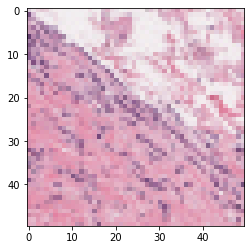

In [ ]:
orig_img = load_img(sample_train_pos[0], target_size=(50, 50))
img = img_to_array(orig_img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)
plt.imshow(orig_img)
img.shape


In [ ]:
model5.predict(img)

array([[0.0015513, 0.9984486]], dtype=float32)

In [ ]:
len(model5.layers)

962

In [ ]:
model = Model(inputs=model5.inputs, outputs=model5.layers[956].output)
# load and preprocess the image 
img = load_img(sample_train_pos[0], target_size=(50, 50))  
x = img_to_array(img)  
x = np.expand_dims(x, axis=0)  
x = preprocess_input(x) 
 
# extract features  
features = model.predict(x) 

In [ ]:
features.shape

(1, 5120)

In [ ]:
model = Model(inputs=model5.inputs, outputs=model5.layers[957].output)
# load and preprocess the image 
img = load_img(sample_train_pos[0], target_size=(50, 50))  
x = img_to_array(img)  
x = np.expand_dims(x, axis=0)  
x = preprocess_input(x) 
 
# extract features  
features = model.predict(x) 

In [ ]:
features.shape

(1, 256)

### Creating an array of training samples

In [ ]:
train_samples =  os.listdir(NEG_TRAIN_DIR) + os.listdir(POS_TRAIN_DIR) 
train_samples_matrix_x = np.zeros((len(train_samples),256))
train_samples_matrix_y = np.zeros((len(train_samples),1))

In [ ]:
NEG_VAL_DIR =  os.path.join(VAL_DIR, "neg")
POS_VAL_DIR =  os.path.join(VAL_DIR, "pos")
val_samples =  os.listdir(NEG_VAL_DIR) + os.listdir(POS_VAL_DIR) 
val_samples_matrix_x = np.zeros((len(val_samples),256))
val_samples_matrix_y = np.zeros((len(val_samples),1))

In [ ]:
NEG_TEST_DIR =  os.path.join(TEST_DIR, "neg")
POS_TEST_DIR =  os.path.join(TEST_DIR, "pos")
test_samples =  os.listdir(NEG_TEST_DIR) + os.listdir(POS_TEST_DIR) 
test_samples_matrix_x = np.zeros((len(test_samples),256))
test_samples_matrix_y = np.zeros((len(test_samples),1))

In [ ]:
train_samples_matrix_x.shape

(171131, 256)

In [ ]:
def add_sample(sample_dir, index, output_y):
  img = load_img(sample_dir, target_size=(50, 50))  
  x = img_to_array(img)  
  x = np.expand_dims(x, axis=0)  
  x = preprocess_input(x) 

  # extract features  
  features = model.predict(x) 
  train_samples_matrix_x[index] = features
  train_samples_matrix_y[index] = output_y


In [ ]:
count = 0
for img_dir in  [str(POS_TRAIN_DIR+"/" + x) for x in os.listdir(POS_TRAIN_DIR)]:
  count += 1
  add_sample(img_dir, count, 1)

for img_dir in os.listdir(NEG_TRAIN_DIR):
  count += 1
  add_sample(img_dir, count, 0)

In [ ]:
np.save('model_3_train_samples_matrix_x.npy', train_samples_matrix_x) # save
np.save('model_3_train_samples_matrix_y.npy', train_samples_matrix_y) # save
#new_num_arr = np.load('data.npy') # load

In [ ]:
def add_sample_val(sample_dir, index, output_y):
  img = load_img(sample_dir, target_size=(50, 50))  
  x = img_to_array(img)  
  x = np.expand_dims(x, axis=0)  
  x = preprocess_input(x) 

  # extract features  
  features = model.predict(x) 
  val_samples_matrix_x[index] = features
  val_samples_matrix_y[index] = output_y


In [ ]:
count = 0
for img_dir in  [str(POS_VAL_DIR+"/" + x) for x in os.listdir(POS_VAL_DIR)]:
  count += 1
  add_sample_val(img_dir, count, 1)

for img_dir in os.listdir(NEG_VAL_DIR):
  count += 1
  add_sample_val(img_dir, count, 0)

In [ ]:
np.save('model_3_val_samples_matrix_x.npy', val_samples_matrix_x) # save
np.save('model_3_val_samples_matrix_y.npy', val_samples_matrix_y) # save
#new_num_arr = np.load('data.npy') # load

In [ ]:
def add_sample_test(sample_dir, index, output_y):
  img = load_img(sample_dir, target_size=(50, 50))  
  x = img_to_array(img)  
  x = np.expand_dims(x, axis=0)  
  x = preprocess_input(x) 

  # extract features  
  features = model.predict(x) 
  test_samples_matrix_x[index] = features
  test_samples_matrix_y[index] = output_y


In [ ]:
count = 0
for img_dir in  [str(POS_TEST_DIR+"/" + x) for x in os.listdir(POS_TEST_DIR)]:
  count += 1
  add_sample_test(img_dir, count, 1)

for img_dir in os.listdir(NEG_TEST_DIR):
  count += 1
  add_sample_test(img_dir, count, 0)

In [ ]:
np.save('model_3_test_samples_matrix_x.npy', test_samples_matrix_x) # save
np.save('model_3_test_samples_matrix_y.npy', test_samples_matrix_y) # save
#new_num_arr = np.load('data.npy') # load

In [ ]:
from sklearn import svm
model5_svm = svm.SVC()
model5_svm.fit(train_samples_matrix_x, train_samples_matrix_y)

# Model 6 
ResNet

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 50
WIDTH = 50

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen_6 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.resnet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
train_generator_6 = train_datagen_6.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen_6 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.resnet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
val_generator_6 = val_datagen_6.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen_6 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.resnet.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator_6 = test_datagen_6.flow_from_directory(TEST_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 53487 images belonging to 2 classes.


In [ ]:
import keras
help(keras.applications)

Help on package keras.applications in keras:

NAME
    keras.applications - Keras Applications are canned architectures with pre-trained weights.

PACKAGE CONTENTS
    densenet
    efficientnet
    efficientnet_v2
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    mobilenet_v3
    nasnet
    resnet
    resnet_v2
    vgg16
    vgg19
    xception

FILE
    /usr/local/lib/python3.7/dist-packages/keras/applications/__init__.py




In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_6 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_6.summary()

# Mark loaded layers as not trainable
for layer in base_model_6.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x6 = Flatten()(base_model_6.layers[-1].output)
x6 = Dense(256, activation='tanh')(x6)
x6 = Dense(256, activation='tanh')(x6)
x6 = Dropout(0.25)(x6)
x6 = Dense(256, activation='tanh')(x6)
output6 = Dense(2, activation='softmax')(x6)

# Define new model
model6 = Model(inputs = base_model_6.inputs, outputs = output6)



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Print summary
#model.summary()

# Compile
model6.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history6 = model6.fit(train_generator_6,
                    validation_data = val_generator_6,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 465s 164ms/step - loss: 0.3413 - accuracy: 0.8591 - val_loss: 0.2958 - val_accuracy: 0.8830
Epoch 2/10
2674/2674 [==============================] - 375s 140ms/step - loss: 0.3133 - accuracy: 0.8707 - val_loss: 0.5461 - val_accuracy: 0.7543
Epoch 3/10
2674/2674 [==============================] - 371s 139ms/step - loss: 0.3035 - accuracy: 0.8751 - val_loss: 0.2915 - val_accuracy: 0.8792
Epoch 4/10
2674/2674 [==============================] - 372s 139ms/step - loss: 0.2980 - accuracy: 0.8769 - val_loss: 0.3506 - val_accuracy: 0.8639
Epoch 5/10
2674/2674 [==============================] - 363s 136ms/step - loss: 0.2945 - accuracy: 0.8790 - val_loss: 0.3589 - val_accuracy: 0.8611
Epoch 6/10
2674/2674 [==============================] - 363s 136ms/step - loss: 0.2906 - accuracy: 0.8804 - val_loss: 0.3378 - val_accuracy: 0.8492
Epoch 7/10
2674/2674 [==============================] - 369s 138ms/step - loss: 0.2882 - accuracy: 0.8811 - val_

In [ ]:
model6.save("model6")
model6.save("model6.h5")

INFO:tensorflow:Assets written to: model6/assets


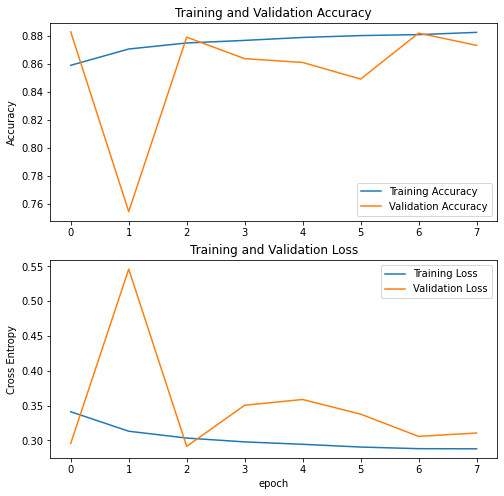

In [ ]:
import matplotlib.pyplot as plt

acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model6.evaluate(test_generator_6)


827/827 [==============================] - 32s 38ms/step - loss: 0.3006 - accuracy: 0.8843


[0.3006092607975006, 0.8842664361000061]

# Model 7
same as model 6 but with less Learning rate

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_7 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_7.summary()

# Mark loaded layers as not trainable
for layer in base_model_7.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x7 = Flatten()(base_model_7.layers[-1].output)
x7 = Dense(256, activation='tanh')(x7)
x7 = Dense(256, activation='tanh')(x7)
x7 = Dropout(0.25)(x7)
x7 = Dense(256, activation='tanh')(x7)
output7 = Dense(2, activation='softmax')(x7)

# Define new model
model7 = Model(inputs = base_model_7.inputs, outputs = output7)



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Print summary
#model.summary()

# Compile
model7.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 2*10**(-5)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history7 = model7.fit(train_generator_6,
                    validation_data = val_generator_6,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 393s 142ms/step - loss: 0.3270 - accuracy: 0.8618 - val_loss: 0.3033 - val_accuracy: 0.8818
Epoch 2/10
2674/2674 [==============================] - 378s 141ms/step - loss: 0.2816 - accuracy: 0.8843 - val_loss: 0.2955 - val_accuracy: 0.8816
Epoch 3/10
2674/2674 [==============================] - 379s 142ms/step - loss: 0.2643 - accuracy: 0.8924 - val_loss: 0.2904 - val_accuracy: 0.8800
Epoch 4/10
2674/2674 [==============================] - 378s 141ms/step - loss: 0.2507 - accuracy: 0.8987 - val_loss: 0.2991 - val_accuracy: 0.8775
Epoch 5/10
2674/2674 [==============================] - 377s 141ms/step - loss: 0.2441 - accuracy: 0.9021 - val_loss: 0.3075 - val_accuracy: 0.8744
Epoch 6/10
2674/2674 [==============================] - 371s 139ms/step - loss: 0.2350 - accuracy: 0.9062 - val_loss: 0.3134 - val_accuracy: 0.8737
Epoch 7/10
2674/2674 [==============================] - 377s 141ms/step - loss: 0.2299 - accuracy: 0.9085 - val_

In [ ]:
model7.save("model7")
model7.save("model7.h5")

INFO:tensorflow:Assets written to: model7/assets


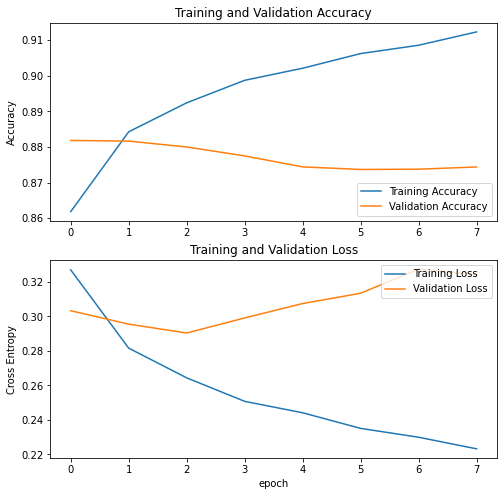

In [ ]:
import matplotlib.pyplot as plt

acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model7.evaluate(test_generator_6)


827/827 [==============================] - 32s 38ms/step - loss: 0.3526 - accuracy: 0.8683


[0.3525882363319397, 0.8683325052261353]

# model 8
same as model 7 but with more regularization

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_8 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_8.summary()

# Mark loaded layers as not trainable
for layer in base_model_8.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x8 = Flatten()(base_model_8.layers[-1].output)
x8 = Dense(256, activation='tanh')(x8)
x8 = Dropout(0.25)(x8)
x8 = Dense(256, activation='tanh')(x8)
x8 = Dropout(0.25)(x8)
x8 = Dense(256, activation='tanh')(x8)
output8 = Dense(2, activation='softmax')(x8)

# Define new model
model8 = Model(inputs = base_model_8.inputs, outputs = output8)



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Print summary
#model.summary()

# Compile
model8.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 2*10**(-5)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history8 = model8.fit(train_generator_6,
                    validation_data = val_generator_6,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 403s 146ms/step - loss: 0.3301 - accuracy: 0.8618 - val_loss: 0.3090 - val_accuracy: 0.8826
Epoch 2/10
2674/2674 [==============================] - 377s 141ms/step - loss: 0.2825 - accuracy: 0.8837 - val_loss: 0.3139 - val_accuracy: 0.8796
Epoch 3/10
2674/2674 [==============================] - 375s 140ms/step - loss: 0.2669 - accuracy: 0.8908 - val_loss: 0.3045 - val_accuracy: 0.8780
Epoch 4/10
2674/2674 [==============================] - 374s 140ms/step - loss: 0.2558 - accuracy: 0.8968 - val_loss: 0.3137 - val_accuracy: 0.8768
Epoch 5/10
2674/2674 [==============================] - 378s 141ms/step - loss: 0.2468 - accuracy: 0.9011 - val_loss: 0.3282 - val_accuracy: 0.8791
Epoch 6/10
2674/2674 [==============================] - 375s 140ms/step - loss: 0.2406 - accuracy: 0.9042 - val_loss: 0.3239 - val_accuracy: 0.8746
Epoch 7/10
2674/2674 [==============================] - 377s 141ms/step - loss: 0.2331 - accuracy: 0.9074 - val_

In [ ]:
model8.save("model8")
model8.save("model8.h5")

INFO:tensorflow:Assets written to: model8/assets


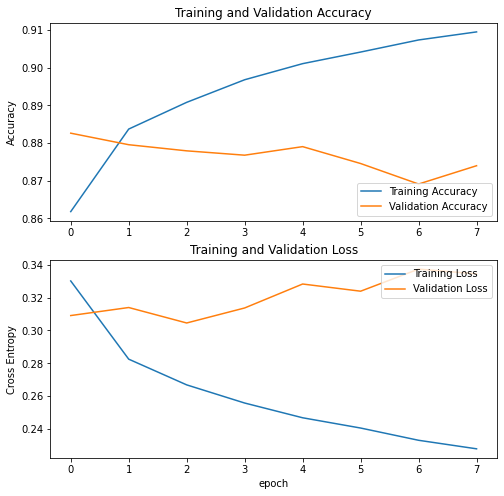

In [ ]:
import matplotlib.pyplot as plt

acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']

loss = history8.history['loss']
val_loss = history8.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model8.evaluate(test_generator_6)


827/827 [==============================] - 32s 39ms/step - loss: 0.3829 - accuracy: 0.8706


[0.38288259506225586, 0.8706384897232056]

# model 9
just model 8 without early stopping

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_9 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_9.summary()

# Mark loaded layers as not trainable
for layer in base_model_9.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x9 = Flatten()(base_model_9.layers[-1].output)
x9 = Dense(256, activation='tanh')(x9)
x9 = Dropout(0.25)(x9)
x9 = Dense(256, activation='tanh')(x9)
x9 = Dropout(0.25)(x9)
x9 = Dense(256, activation='tanh')(x9)
output9 = Dense(2, activation='softmax')(x9)

# Define new model
model9 = Model(inputs = base_model_9.inputs, outputs = output9)



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# Print summary
#model.summary()

# Compile
model9.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 2*10**(-5)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history8 = model9.fit(train_generator_6,
                    validation_data = val_generator_6,
                    epochs = 10,
                    #callbacks=[es]
                    )

Epoch 1/10
 861/2674 [========>.....................] - ETA: 3:54 - loss: 0.3698 - accuracy: 0.8444

# model 10

same as model 9 but with different classifier

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_10 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_10.summary()

# Mark loaded layers as not trainable
for layer in base_model_10.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x10 = Flatten()(base_model_10.layers[-1].output)
x10 = Dense(512, activation='tanh')(x10)
x10 = Dropout(0.25)(x10)
x10 = Dense(256, activation='tanh')(x10)
#x10 = Dropout(0.25)(x10)
x10 = Dense(128, activation='tanh')(x10)
output10 = Dense(2, activation='softmax')(x10)

# Define new model
model10 = Model(inputs = base_model_10.inputs, outputs = output10)



In [ ]:
# Print summary
#model.summary()

# Compile
model10.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 2*10**(-5)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history10 = model10.fit(train_generator_6,
                    validation_data = val_generator_6,
                    epochs = 10,
                    callbacks=[es]
                    )

Epoch 1/10
 440/2674 [===>..........................] - ETA: 8:42 - loss: 0.3858 - accuracy: 0.8377

In [ ]:
model10.save("model10")
model10.save("model10.h5")

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# model 11
medium EfficientNet

In [ ]:
import keras
help(keras.applications)

Help on package keras.applications in keras:

NAME
    keras.applications - Keras Applications are canned architectures with pre-trained weights.

PACKAGE CONTENTS
    densenet
    efficientnet
    efficientnet_v2
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    mobilenet_v3
    nasnet
    resnet
    resnet_v2
    vgg16
    vgg19
    xception

FILE
    /usr/local/lib/python3.7/dist-packages/keras/applications/__init__.py




In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 50
WIDTH = 50

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen_11 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
train_generator_11 = train_datagen_11.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen_11 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
val_generator_11 = val_datagen_11.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen_11 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator_11 = test_datagen_11.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
from keras.applications.efficientnet import EfficientNetB3
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_11 = EfficientNetB3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_11.summary()

# Mark loaded layers as not trainable
for layer in base_model_11.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x11 = Flatten()(base_model_11.layers[-1].output)
x11 = Dense(256, activation='tanh')(x11)
x11 = Dropout(0.25)(x11)
x11 = Dense(256, activation='tanh')(x11)
x11 = Dropout(0.25)(x11)
x11 = Dense(256, activation='tanh')(x11)
output11 = Dense(2, activation='softmax')(x11)

# Define new model
model11 = Model(inputs = base_model_11.inputs, outputs = output11)



43950080/43941136 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 50, 50, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 50, 50, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 51, 51, 3)    0           ['normalization[0][0]']          
                    

In [ ]:
# Print summary
#model.summary()

# Compile
base_learning_rate = 0.0001
model11.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history11 = model11.fit(train_generator_11,
                    validation_data = val_generator_11,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 865s 307ms/step - loss: 0.3505 - accuracy: 0.8516 - val_loss: 0.2992 - val_accuracy: 0.8850
Epoch 2/10
2674/2674 [==============================] - 742s 278ms/step - loss: 0.3124 - accuracy: 0.8691 - val_loss: 0.3224 - val_accuracy: 0.8530
Epoch 3/10
2674/2674 [==============================] - 746s 279ms/step - loss: 0.3097 - accuracy: 0.8706 - val_loss: 0.2904 - val_accuracy: 0.8785
Epoch 4/10
2674/2674 [==============================] - 746s 279ms/step - loss: 0.3072 - accuracy: 0.8711 - val_loss: 0.3153 - val_accuracy: 0.8715
Epoch 5/10
2674/2674 [==============================] - 744s 278ms/step - loss: 0.2990 - accuracy: 0.8754 - val_loss: 0.2944 - val_accuracy: 0.8863
Epoch 6/10
2674/2674 [==============================] - 743s 278ms/step - loss: 0.2940 - accuracy: 0.8798 - val_loss: 0.2863 - val_accuracy: 0.8843
Epoch 7/10
2674/2674 [==============================] - 741s 277ms/step - loss: 0.2864 - accuracy: 0.8838 - val_

In [ ]:
model11.save("model11.h5")

In [ ]:
model11.evaluate(test_generator_11)


827/827 [==============================] - 69s 83ms/step - loss: 0.3137 - accuracy: 0.8698


[0.313650906085968, 0.8697690367698669]

827/827 [==============================] - 60s 72ms/step - loss: 0.3137 - accuracy: 0.8698


[0.31365084648132324, 0.8697690367698669]

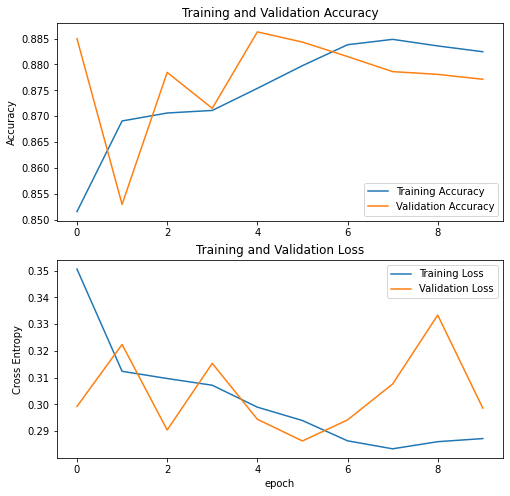

In [ ]:
import matplotlib.pyplot as plt

acc = history11.history['accuracy']
val_acc = history11.history['val_accuracy']

loss = history11.history['loss']
val_loss = history11.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model 12 
Just as model 6 but with not training the whole network 

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_11 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_11.summary()

# Mark loaded layers as not trainable
for layer in base_model_11.layers:
  layer.trainable = False

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x11 = Flatten()(base_model_11.layers[-1].output)
x11 = Dense(256, activation='tanh')(x11)
x11 = Dense(256, activation='tanh')(x11)
x11 = Dropout(0.25)(x11)
x11 = Dense(256, activation='tanh')(x11)
output6 = Dense(2, activation='softmax')(x11)

# Define new model
model11 = Model(inputs = base_model_11.inputs, outputs = output6)



In [ ]:
# Print summary
#model.summary()

# Compile
model11.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history11 = model11.fit(train_generator_6,
                    validation_data = val_generator_6,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 398s 142ms/step - loss: 0.3892 - accuracy: 0.8357 - val_loss: 0.3486 - val_accuracy: 0.8600
Epoch 2/10
2674/2674 [==============================] - 296s 111ms/step - loss: 0.3737 - accuracy: 0.8446 - val_loss: 0.3462 - val_accuracy: 0.8565
Epoch 3/10
2674/2674 [==============================] - 284s 106ms/step - loss: 0.3702 - accuracy: 0.8481 - val_loss: 0.3552 - val_accuracy: 0.8601
Epoch 4/10
2674/2674 [==============================] - 283s 106ms/step - loss: 0.3696 - accuracy: 0.8492 - val_loss: 0.3490 - val_accuracy: 0.8577
Epoch 5/10
2674/2674 [==============================] - 287s 107ms/step - loss: 0.3676 - accuracy: 0.8510 - val_loss: 0.3574 - val_accuracy: 0.8465
Epoch 6/10
2674/2674 [==============================] - 287s 107ms/step - loss: 0.3679 - accuracy: 0.8504 - val_loss: 0.3457 - val_accuracy: 0.8597
Epoch 7/10
2674/2674 [==============================] - 281s 105ms/step - loss: 0.3670 - accuracy: 0.8506 - val_

In [ ]:
model11.save("model11")
model11.save("model11.h5")

INFO:tensorflow:Assets written to: model11/assets


In [ ]:
model11.evaluate(test_generator_6)


836/836 [==============================] - 52s 63ms/step - loss: 0.3768 - accuracy: 0.8494


[0.37675973773002625, 0.8493652939796448]

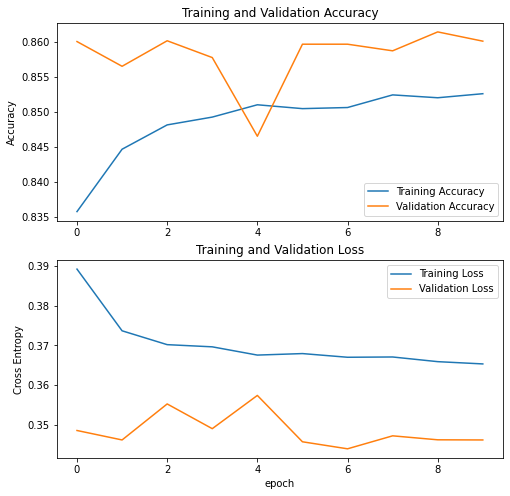

In [ ]:
import matplotlib.pyplot as plt

acc = history11.history['accuracy']
val_acc = history11.history['val_accuracy']

loss = history11.history['loss']
val_loss = history11.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model 15

Inception

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 75
WIDTH = 75

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen_15 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
train_generator_15 = train_datagen_15.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen_15 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
val_generator_15 = val_datagen_15.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen_15 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator_15 = test_datagen_15.flow_from_directory(TEST_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 53487 images belonging to 2 classes.


In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1A7gMSue-zJw6biiZA5wVXG-VOLz3kkiE'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('model15.h5')


In [ ]:
import keras

In [ ]:
model15 = keras.models.load_model('/content/model15.h5')

In [ ]:
model15.evaluate(test_generator_15)


836/836 [==============================] - 69s 65ms/step - loss: 0.3105 - accuracy: 0.8729


[0.3104522228240967, 0.8729410767555237]

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_15 = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_15.summary()

# Mark loaded layers as not trainable
for layer in base_model_15.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x15 = Flatten()(base_model_15.layers[-1].output)
x15 = Dense(256, activation='tanh')(x15)
x15 = Dense(256, activation='tanh')(x15)
x15 = Dropout(0.25)(x15)
x15 = Dense(256, activation='tanh')(x15)
x15 = Dense(256, activation='tanh')(x15)
output15 = Dense(2, activation='softmax')(x15)

# Define new model
model15 = Model(inputs = base_model_15.inputs, outputs = output15)



Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 37, 37, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 37, 37, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_188 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

In [ ]:
# Print summary
#model.summary()

# Compile
model15.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history15 = model15.fit(train_generator_15,
                    validation_data = val_generator_15,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 579s 207ms/step - loss: 0.3419 - accuracy: 0.8572 - val_loss: 0.3418 - val_accuracy: 0.8553
Epoch 2/10
2674/2674 [==============================] - 486s 182ms/step - loss: 0.3139 - accuracy: 0.8710 - val_loss: 0.3203 - val_accuracy: 0.8661
Epoch 3/10
2674/2674 [==============================] - 476s 178ms/step - loss: 0.3143 - accuracy: 0.8698 - val_loss: 0.3401 - val_accuracy: 0.8399
Epoch 4/10
2674/2674 [==============================] - 475s 178ms/step - loss: 0.3201 - accuracy: 0.8658 - val_loss: 0.3114 - val_accuracy: 0.8627
Epoch 5/10
2674/2674 [==============================] - 475s 178ms/step - loss: 0.3083 - accuracy: 0.8713 - val_loss: 0.3115 - val_accuracy: 0.8744
Epoch 6/10
2674/2674 [==============================] - 477s 178ms/step - loss: 0.3058 - accuracy: 0.8710 - val_loss: 0.3649 - val_accuracy: 0.8365
Epoch 7/10
2674/2674 [==============================] - 480s 179ms/step - loss: 0.3046 - accuracy: 0.8723 - val_

In [ ]:
model15.save("model15")
model15.save("model15.h5")

INFO:tensorflow:Assets written to: model15/assets


In [ ]:
model15.evaluate(test_generator_15)


836/836 [==============================] - 57s 67ms/step - loss: 0.3105 - accuracy: 0.8729


[0.31045201420783997, 0.8729410767555237]

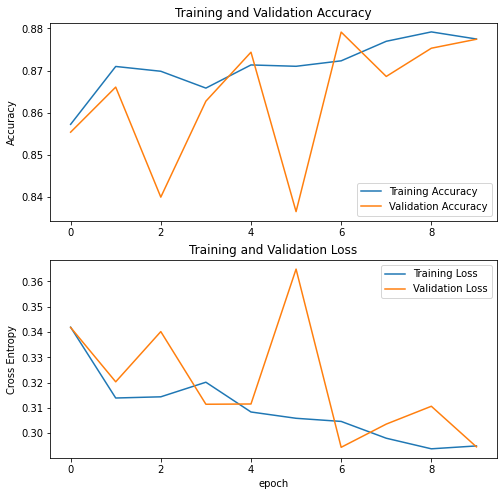

In [ ]:
import matplotlib.pyplot as plt

acc = history15.history['accuracy']
val_acc = history15.history['val_accuracy']

loss = history15.history['loss']
val_loss = history15.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model 16

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 12.6 MB/s 


In [ ]:
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf
class Model16(kt.HyperModel):
  def build(self, hp):
      base_model_16 = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))
      for layer in base_model_16.layers:
        layer.trainable = hp.Choice('trainAll', values=[True,False])

      x = Flatten()(base_model_16.layers[-1].output)
      for i in range(hp.Choice('numLayers', values=[2,3,4])):
          x = Dense(hp.Choice('x1_{}'.format(i), values=[768,512,256]), activation=hp.Choice('act1_{}'.format(i), values=['tanh', 'relu']))(x)
          x = Dropout(hp.Choice('d1_{}'.format(i), values=[0.0,0.25]))(x)
     
      output16 = Dense(2, activation='softmax')(x)

      model16 = Model(inputs = base_model_16.inputs, outputs = output16)

      model16.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
      return model16
  


In [ ]:
import tensorflow as tf

# Define an EarlyStopping callback to use with all models
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def search(tuner, epochs=1):
  """
  Uses the provided Keras tuner to search the hyperparameter space
  Returns the best hyperparameters
  """
  # Search the hyperparameter space
  tuner.search(train_generator_15,
             validation_data = val_generator_15,
             epochs = epochs,
             callbacks = [stop_early]
             )
  
  # Get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  
  return best_hps

In [ ]:
task16_tuner = kt.BayesianOptimization(
    Model16(),
    objective='val_loss',
    max_trials=10)

87924736/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
best_hps_16 = search(task16_tuner,1)

Trial 10 Complete [00h 12m 28s]
val_loss: 0.49590417742729187

Best val_loss So Far: 0.30968672037124634
Total elapsed time: 02h 08m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_16.get('trainAll'),best_hps_16.get('numLayers'),best_hps_16.get('x1_1'),best_hps_16.get('act1_1'),best_hps_16.get('x1_2'),best_hps_16.get('act1_2'),

(1, 3, 768, 'tanh', 768, 'tanh')

In [ ]:
best_hps_16.get('d1_1'),best_hps_16.get('d1_2')

(0.25, 0.0)

In [ ]:
best_hps_16.get('x1_0'),best_hps_16.get('act1_0'),best_hps_16.get('d1_0')

(768, 'tanh', 0.0)

# Model 17

Fine Tuning model 2

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf
class Model17(kt.HyperModel):
  def build(self, hp):
      base_model_16 = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))
      for layer in base_model_16.layers:
        layer.trainable = hp.Choice('trainAll', values=[True,False])

      x = Flatten()(base_model_16.layers[-1].output)
      for i in range(hp.Choice('numLayers', values=[1,2,3,4])):
          x = Dense(hp.Choice('x1_{}'.format(i), values=[768,512,256]), activation=hp.Choice('act1_{}'.format(i), values=['tanh', 'relu']))(x)
          x = Dropout(hp.Choice('d1_{}'.format(i), values=[0.0,0.25]))(x)
     
      output16 = Dense(2, activation='softmax')(x)

      model = Model(inputs = base_model_16.inputs, outputs = output16)

      model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
      return model
  


In [ ]:
import tensorflow as tf

# Define an EarlyStopping callback to use with all models
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def search(tuner, epochs=10):
  """
  Uses the provided Keras tuner to search the hyperparameter space
  Returns the best hyperparameters
  """
  # Search the hyperparameter space
  tuner.search(train_generator_6,
             validation_data = val_generator_16,
             epochs = epochs,
             callbacks = [stop_early]
             )
  
  # Get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  
  return best_hps

In [ ]:
task17_tuner = kt.BayesianOptimization(
    Model17(),
    objective='val_loss',
    max_trials=10)

In [ ]:
best_hps_17 = search(task17_tuner)

# Model 20

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_20 = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_20.summary()

# Mark loaded layers as not trainable
for layer in base_model_20.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x20 = Flatten()(base_model_20.layers[-1].output)
x20 = Dense(768, activation='tanh')(x20)
x20 = Dense(768, activation='tanh')(x20)
x20 = Dropout(0.25)(x20)
x20 = Dense(768, activation='tanh')(x20)
output20 = Dense(2, activation='softmax')(x20)

# Define new model
model20 = Model(inputs = base_model_20.inputs, outputs = output20)



In [ ]:
# Print summary
#model.summary()

# Compile
model20.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 5.5*10**(-4)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history20 = model20.fit(train_generator_15,
                    validation_data = val_generator_15,
                    epochs = 10,)

Epoch 1/10
2674/2674 [==============================] - 739s 271ms/step - loss: 0.3428 - accuracy: 0.8555 - val_loss: 0.3040 - val_accuracy: 0.8754
Epoch 2/10
2674/2674 [==============================] - 721s 270ms/step - loss: 0.3052 - accuracy: 0.8743 - val_loss: 0.3663 - val_accuracy: 0.8341
Epoch 3/10
2674/2674 [==============================] - 721s 270ms/step - loss: 0.3120 - accuracy: 0.8724 - val_loss: 0.3949 - val_accuracy: 0.8273
Epoch 4/10
2674/2674 [==============================] - 717s 268ms/step - loss: 0.3138 - accuracy: 0.8687 - val_loss: 0.3472 - val_accuracy: 0.8592
Epoch 5/10
2674/2674 [==============================] - 716s 268ms/step - loss: 0.3058 - accuracy: 0.8724 - val_loss: 0.3154 - val_accuracy: 0.8760
Epoch 6/10
2674/2674 [==============================] - 721s 269ms/step - loss: 0.3042 - accuracy: 0.8738 - val_loss: 0.2868 - val_accuracy: 0.8873
Epoch 7/10
2674/2674 [==============================] - 723s 270ms/step - loss: 0.2975 - accuracy: 0.8774 - val_

In [ ]:
model20.evaluate(test_generator_15)


836/836 [==============================] - 80s 95ms/step - loss: 0.2951 - accuracy: 0.8625


[0.29512545466423035, 0.8625086545944214]

In [ ]:
model20.save("model20.h5")

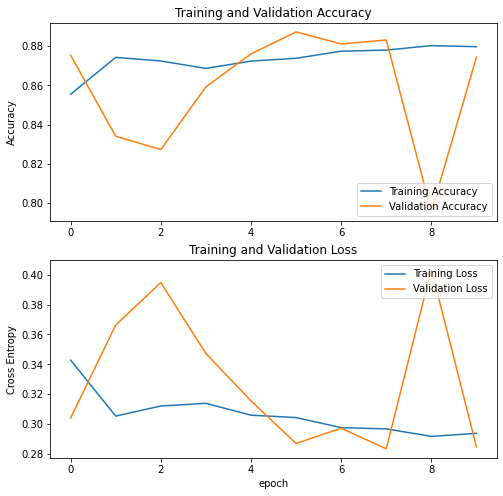

In [ ]:
import matplotlib.pyplot as plt

acc = history20.history['accuracy']
val_acc = history20.history['val_accuracy']

loss = history20.history['loss']
val_loss = history20.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model 25

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
HEIGHT = 71
WIDTH = 71

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen_25 =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.densenet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
train_generator_25 = train_datagen_25.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 171131 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
val_datagen_25 =  ImageDataGenerator(
      preprocessing_function =  tf.keras.applications.densenet.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
    )

# 2. Retrieve the iterator
val_generator_25 = val_datagen_25.flow_from_directory(VAL_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 52906 images belonging to 2 classes.


In [ ]:
# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen_25 =  ImageDataGenerator(
      preprocessing_function =  tf.keras.applications.densenet.preprocess_input,
    )

# 2. Retrieve the iterator
test_generator_25 = test_datagen_25.flow_from_directory(TEST_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 53487 images belonging to 2 classes.


In [ ]:
import keras
help(keras.applications)

Help on package keras.applications in keras:

NAME
    keras.applications - Keras Applications are canned architectures with pre-trained weights.

PACKAGE CONTENTS
    densenet
    efficientnet
    efficientnet_v2
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    mobilenet_v3
    nasnet
    resnet
    resnet_v2
    vgg16
    vgg19
    xception

FILE
    /usr/local/lib/python3.7/dist-packages/keras/applications/__init__.py




In [ ]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Load model without classification head
base_model_25 = DenseNet121(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Print base model summary
base_model_25.summary()

# Mark loaded layers as not trainable
for layer in base_model_25.layers:
  layer.trainable = True

# You can choose to fine-tune some of the final layers:
# for layer in base_model.layers[:25]:
#  layer.trainable = False

# You can pick which layers are trainable and which are not:
#base_model.get_layer('block1_conv1').trainable = False


# Add new classifier layers
x25 = Flatten()(base_model_25.layers[-1].output)
x25 = Dense(265, activation='tanh')(x25)
x25 = Dense(265, activation='tanh')(x25)
x25 = Dropout(0.25)(x25)
x25 = Dense(265, activation='tanh')(x25)
output25 = Dense(2, activation='softmax')(x25)

# Define new model
model25 = Model(inputs = base_model_25.inputs, outputs = output25)



29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 77, 77, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 36, 36, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 36, 36, 64)   256         ['conv1/conv[0][0]']             
                       

In [ ]:
# Print summary
#model.summary()

# Compile
model25.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 2*10**(-5)),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history25 = model25.fit(train_generator_25,
                    validation_data = val_generator_25,
                    epochs = 10,
                    callbacks=[es])

Epoch 1/10
2674/2674 [==============================] - 623s 220ms/step - loss: 0.3252 - accuracy: 0.8635 - val_loss: 0.2804 - val_accuracy: 0.8866
Epoch 2/10
2674/2674 [==============================] - 537s 201ms/step - loss: 0.2762 - accuracy: 0.8853 - val_loss: 0.2650 - val_accuracy: 0.8882
Epoch 3/10
2674/2674 [==============================] - 520s 194ms/step - loss: 0.2577 - accuracy: 0.8940 - val_loss: 0.2609 - val_accuracy: 0.8906
Epoch 4/10
  40/2674 [..............................] - ETA: 9:26 - loss: 0.2329 - accuracy: 0.9039

In [ ]:
import matplotlib.pyplot as plt

acc = history25.history['accuracy']
val_acc = history25.history['val_accuracy']

loss = history25.history['loss']
val_loss = history25.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()